In [69]:
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re

In [89]:
colors0 = ['#F77979', '#AFDA41', '#CE6E51', '#EC8F2F', '#E2E23F', '#93C57E', '#13A691', '#8A72BD', '#E197E2', 
          '#E87F60', '#F7C940', '#8CC102', '#3D7F3F', '#086B4B', '#77EDF7', '#4D518E', '#C15DA1', '#AF6577',
          '#C1735B', '#9E8615', '#8BC161', '#084E27', '#719FA8', '#807C9A', '#805390', '#D686C8', '#BF5376']
colors = (px.colors.qualitative.Set3) + (px.colors.qualitative.Pastel1) + (px.colors.qualitative.Pastel)
len(colors)

34

In [91]:
# construct the data
data_path = "../Data"
selected_food_map_per_c = {"cereals": ["Cereals - Excluding Beer"], "meat": ["Meat", "Offals", "Animal fats"], "milk&eggs": ["Eggs", "Milk - Excluding Butter"], "aquatic food":["Fish, Seafood", "Aquatic Products, Other"], 
                            "fruit&veg": ["Vegetables", "Fruits - Excluding Wine"], "oil":["Oilcrops", "Vegetable Oils"], "nuts": ["Treenuts"], "beans":["Pulses"], 
                            "roots": ["Starchy Roots"], "sugar": ["Sugar & Sweeteners"], "other": ["Stimulants", "Spices", "Alcoholic Beverages"]}
countries = ["Swiss", "China", "India", "Thai", "UK", "Germany", "USA", "Italy", "SAfrica"]
for country in countries:
    country_production = pd.read_excel(os.path.join(data_path, "GlobalData/countryProdYears.xlsx"), sheet_name = country)
    unnecessary_cols = [col for col in country_production.columns if (col != 'Item' and col != 'Area') and not any(char.isdigit() for char in col)]
    country_production = country_production.drop(columns=unnecessary_cols)
    fooditem_list = []
    year_cols = [col for col in country_production.columns if any(char.isdigit() for char in col)]
    for food in selected_food_map_per_c.keys():
        rows_to_add = country_production[country_production['Item'].isin(selected_food_map_per_c[food])]
        new_df = rows_to_add.groupby(('Area'))[year_cols].sum().reset_index()
        new_df["Item"] = food
        fooditem_list.append(new_df)

    country_production = pd.concat(fooditem_list, ignore_index=True)
    country_production = country_production.drop(columns=["Area"])
    country_production = country_production.melt(id_vars='Item', var_name='Year', value_name='Value')
    country_production['Year'] = country_production['Year'].str.extract('(\d+)', expand=False).astype(int)
    
    # construct the first chart
    year = country_production['Year'].min()
    df_filtered = country_production[country_production['Year'] == year]
    pie_num = len(df_filtered['Item'].unique())
    pie_color = colors[0:pie_num]
    fig = go.Figure(data=[go.Pie(labels=df_filtered['Item'], values=df_filtered['Value'], marker=dict(colors=pie_color), textposition="inside")])
    fig.update_layout(title="Different food category production [1961-2013] in " + country)

    # create the slider
    year_slider = go.layout.Slider(
        active=0,
        steps=[{'label': str(year), 'method': 'update', 'args': [{'values': [country_production[country_production['Year'] == year]['Value']], 'title': f"food production ({year})"}]} for year in country_production['Year'].unique()],
        currentvalue={'prefix': 'Year: '},
    )

    # update the pie chart according to the slider
    fig.update_layout(sliders=[year_slider])

    fig.show(renderer="iframe")
    fig.write_html("../website/country_pages/" + country + "Prod.html")


In [72]:
foodgroup_contrib_original = pd.read_excel(os.path.join(data_path, "Global.xlsx"), sheet_name = 'Table S2', skiprows = 1)
selected_food_map = {"cereals": ["cereals"], "meat": ["chicken", "pork", "ruminant_meat"], "milk&eggs": ["dairy", "eggs"], "aquatic food":["fish"], 
                    "fruit&veg": ["fruits", "vegetables", "legumes"], "oil":["oil"], "nuts": ["nuts"], "beans":["soybeans"], 
                    "roots": ["roots"], "sugar": ["sugar"], "other": ["other"]}

foodgroup_contrib_list = []
all_nutrients = ["Energy", "Protein", "Iron", "Calcium", "Vitamin B12", "Folate", "Vitamin E", "Choline"]
for food in selected_food_map.keys():
    rows_to_add = foodgroup_contrib_original[foodgroup_contrib_original['Food group'].isin(selected_food_map[food])]
    new_df = rows_to_add.groupby(('Region'))[all_nutrients].sum().reset_index()
    new_df["Food group"] = food
    foodgroup_contrib_list.append(new_df)

foodgroup_contrib = pd.concat(foodgroup_contrib_list, ignore_index=True)
foodgroup_contrib.head()

,Region,Energy,Protein,Iron,Calcium,Vitamin B12,Folate,Vitamin E,Choline,Food group
0,China,0.490248,0.341884,0.361084,0.083833,0.0,0.189607,0.206247,0.165830,cereals
1,East Asia & Pacific,0.329435,0.401495,0.393697,0.124460,0.0,0.241784,0.063029,0.209859,cereals
2,Europe & Central Asia,0.448411,0.417633,0.560702,0.091629,0.0,0.357855,0.154714,0.267914,cereals
3,High income,0.434355,0.339717,0.482498,0.066771,0.0,0.249864,0.242597,0.211144,cereals
4,India,0.610030,0.581884,0.586713,0.133449,0.0,0.293999,0.411259,0.384583,cereals


In [76]:
food_groups = foodgroup_contrib['Food group'].unique()
regions = foodgroup_contrib['Region'].unique()
# energy_contrib = foodgroup_contrib[['Food group', 'Region', 'Energy']]
bar_color = colors[0:len(food_groups)]
# fig = go.Figure()

for nutrient in all_nutrients:
    stack_bar = px.bar(data_frame=foodgroup_contrib, x="Region", y=nutrient, color="Food group", color_discrete_sequence = bar_color, text_auto=False)
    stack_bar.show(renderer="iframe")
    stack_bar.write_html("../website/global_pages/"+nutrient+"_contrib.html")

In [58]:
stack_bar.write_html("../website/global_pages/energy_contrib.html")

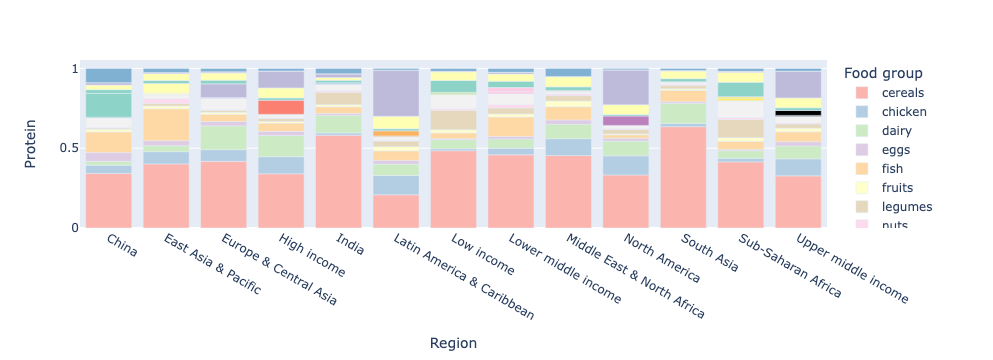

In [59]:
Protein_contrib = foodgroup_contrib[['Food group', 'Region', 'Protein']]
# fig = go.Figure()

stack_bar1 = px.bar(data_frame=foodgroup_contrib, x="Region", y='Protein', color="Food group", color_discrete_sequence = bar_color, text_auto=False)
stack_bar1.show(renderer="iframe")


In [60]:
stack_bar1.write_html("../website/global_pages/protein_contrib.html")